# Comparison CNOGpro, CNVnator, sequana_coverage for the detection of CNVs (bacteria case)

Following the test case found in the CNOGpro paper (see link below), we looked at 6 different strains of staphylococcus available on ENA as FastQ files.

In the paper, they found 37, 37, 25, 27, 27, 26 events in the 6 differents data sets.

https://academic.oup.com/bioinformatics/article/31/11/1708/2365681

as shown in the supplementary SD1.

Here, we used sequana_coverage (http://github.com/sequana/sequana) and CNVnator (https://github.com/abyzovlab/CNVnator) to detect CNV-like events (e.g. longer than 1000 bases) and compare the results with CNOGpro.

In [7]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [12,8]

Populating the interactive namespace from numpy and matplotlib


# Generate the 6 BED files for sequana_coverage

You can download the data from EBI and the reference using sequana_coverage or your 
favorite tool:

In order to download the 6 paired  FastQ files and the reference, perform the mapping, and convert the BAM into BED files, 
you you use the file **download.py** and execute it. Here below are the instructions for one isolate

In [2]:
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR043/ERR043375/ERR043375_1.fastq.gz -c -N 1>out 2>err
!wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR043/ERR043375/ERR043375_2.fastq.gz -c -N 1>out 2>err
!sequana_coverage --download-reference FN433596    

INFO    [sequana]:  Downloading reference FN433596 from ENA



Perform the mapping

In [4]:
!sequana_mapping --file1 ERR043375_1.fastq.gz --file2 ERR043375_2.fastq.gz --reference FN433596.fa 1>out 2>err
!mv FN433596.fa.sorted.bam ERR043375.bam
!bedtools genomecov -d -ibam ERR043375.bam > ERR043375.bed

mv: cannot stat ‘FN433575.fa.sorted.bam’: No such file or directory
Failed to open BAM file ERR043375.bam


Repeat the two steps for these other accession numbers:

- ERR316404
- ERR142616
- ERR043379
- ERR043367
- ERR043371


# use sequana_coverage to get the ROIs

In [4]:
!sequana_coverage -w 40001 -o --output-directory report_ERR043367 --input ERR043367.bed  1>out 2>err

In [5]:
!sequana_coverage -w 40001 -o --output-directory report_ERR043375 --input ERR043375.bed  1>out 2>err

In [6]:
!sequana_coverage -w 40001 -o --output-directory report_ERR043371 --input ERR043371.bed  1>out 2>err

In [7]:
!sequana_coverage -w 40001 -o  --output-directory report_ERR043379 --input ERR043379.bed 1>out 2>err

In [8]:
!sequana_coverage -w 40001 -o --output-directory report_ERR142616 --input ERR142616.bed  1>out 2>err

In [10]:
!sequana_coverage -w 40001 -o --output-directory report_ERR316404 --input ERR316404.bed  1>out 2>err

In [12]:
!cp report_ERR043371/*/*/rois.csv roi_ERR043371.csv
!cp report_ERR043375/*/*/rois.csv roi_ERR043375.csv
!cp report_ERR043367/*/*/rois.csv roi_ERR043367.csv
!cp report_ERR043379/*/*/rois.csv roi_ERR043379.csv
!cp report_ERR142616/*/*/rois.csv roi_ERR142616.csv
!cp report_ERR316404/*/*/rois.csv roi_ERR316404.csv

# Visualisation

In [5]:
import pandas as pd

In [6]:
roi1 = pd.read_csv("roi_ERR043367.csv")
roi2 = pd.read_csv("roi_ERR043371.csv")
roi3 = pd.read_csv("roi_ERR043375.csv")
roi4 = pd.read_csv("roi_ERR043379.csv")   #the one used to plot a coverage signal 
roi5 = pd.read_csv("roi_ERR142616.csv")
roi6 = pd.read_csv("roi_ERR316404.csv")

A convenient function that plot the coverage corresponding to the strain ERR043379 (only) on top of which, the ROIs found by sequana_covereage are shown for the 6 strains as colored-horizontal lines

In [16]:
# We divide the fifth case by 10 to show on the same scale more or less
def plot_rois(m1=85000, m2=90000, ymax=500):
    from sequana import GenomeCov
    b = GenomeCov("ERR043379.bed")
    chromosome = b.chr_list[0]
    N = len(chromosome.df)
    chromosome._df = chromosome.df.iloc[max(0,m1-40001): min(m2+40001, N)]
    chromosome.running_median(40001)
    chromosome.compute_zscore(k=2)
    
    #chromosome.df = chromosome.df.iloc[m1:m2]
    chromosome.plot_coverage()

    i = 1
    for roi, color in zip([roi1, roi2, roi3, roi4, roi5, roi6], ["r", "g", "y", "k", "m", "orange"]):
        for start, end, cov in zip(roi.start, roi.end, roi.mean_cov):
            if i == 5:
                plot([start, end], [cov/10., cov/10.], lw=2, color=color, marker="o")
            else:
                plot([start, end], [cov, cov], lw=2, color=color, marker="o")
        i+=1
        xlim([m1,m2])
        ylim([0,ymax])

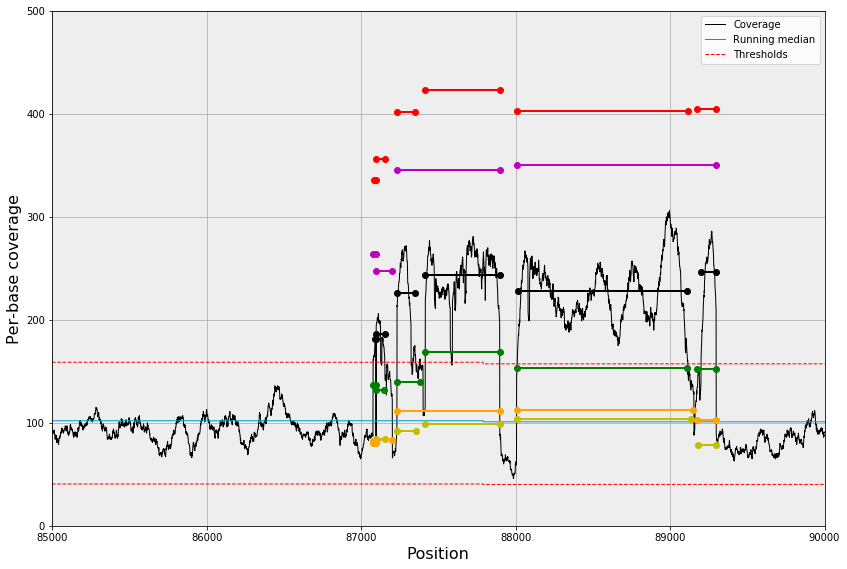

In [17]:
plot_rois(85000, 90000)

Here we focus on a quite complex pattern from position 87000 to 89500. The black line corresponds to the coverage of the strain ERR043379. The colored short horizontal lines correspond to the detected ROIs from sequana_coverage. The black horizontal lines correspond to the ROIs found in ERR043379. The other colored lines correspond to the 5 other strains, for which the coverage is not shown for simplicity. What we see is that the same events are detected in the 6 strains (that have different coverage). We see that there are 5-6 different events very close to each others.

The sequana_coverage code detects more events than CNOGpro but this could be events split into several sub-events so we will need more investigations and plotting tools  hereafter

### number of events detected by sequana_coverage.


In [18]:
len(roi1), len(roi2), len(roi3), len(roi4), len(roi5), len(roi6)

(69, 71, 78, 69, 115, 90)

# IS431-1 between 58553-59342 and IS432-2 at 66346-67135

The genomic region here above include the IS431-1 and IS431-2 (gray regions). This genomic region

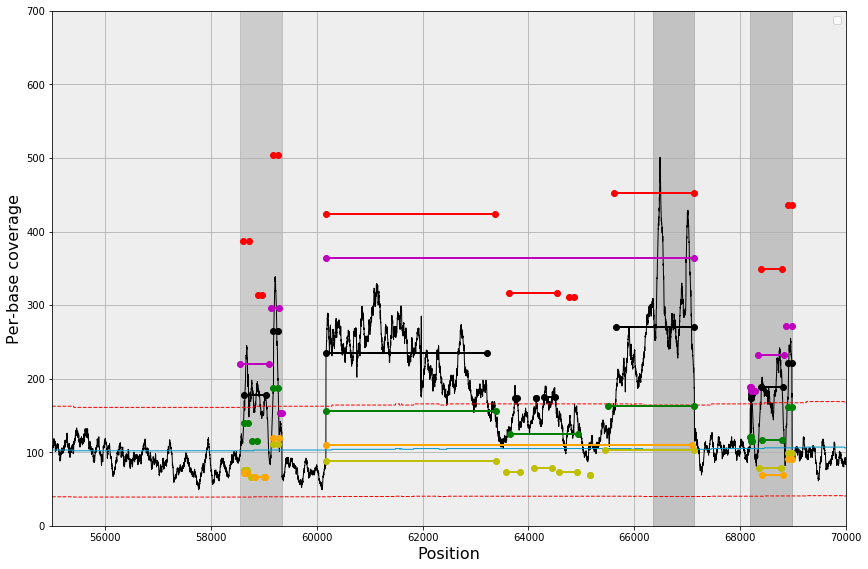

In [19]:
plot_rois(55000, 70000)
legend([])
ylim([0, 700])
fill_between([58553, 59342], 700, 0, color="gray", alpha=0.3)
fill_between([66346, 67135], 700, 0, color="gray", alpha=0.4)
fill_between([68188, 68977], 700, 0, color="gray", alpha=0.4)

# Copy number estimation

it could be interesting to estimate the copy number as reported in CNOGpro or CNVnator. Here is a simple tool to do so.
We extract the data between the starting and ending point reported by sequana_coverage. We use the mean coverage 
and running median (average) of the events. This will be our estimate. 

In [20]:
rois = [roi1, roi2 ,roi3, roi4, roi5, roi6]
CNs = []
def get_CN(m1,m2):
    CN = []
    for roi in rois:
        X = roi.query("start>@m1 and end<@m2");
        if len(X):
            CN.append((X['mean_cov'] / X['mean_rm']).mean())
    return CN
get_CN(58000, 60000)


[2.1520153005475828,
 2.2126968120576294,
 2.3494181401588805,
 2.1499627497045868,
 1.985491529219894,
 2.383655117099341]

# CNV event

Let us focus on an event located at position 2874468. We can check that it is detected with Sequana_coverage in the 6 strains and that its size is systematically equal to 3064 bases

In [21]:
for this in rois: print(this.query("start>2870000 and size>3000 and end<2878000")['size'].values)

[3064]
[3064]
[3064]
[3064]
[3064]
[3064]


In the plot here below, we plot the results from sequana_coverage showing the 6 strains with 
6 different colors.The green and red colored area shows the events reported by CNOGpro. Colors have no meaning but are shown 
to emphasize the fact that CNOGpro reported 6 consecutives events here. They could most probably be merged. More importantly, 
what is noticeable is that the precision of the starting and ending position of the event lack precision on this instance. 


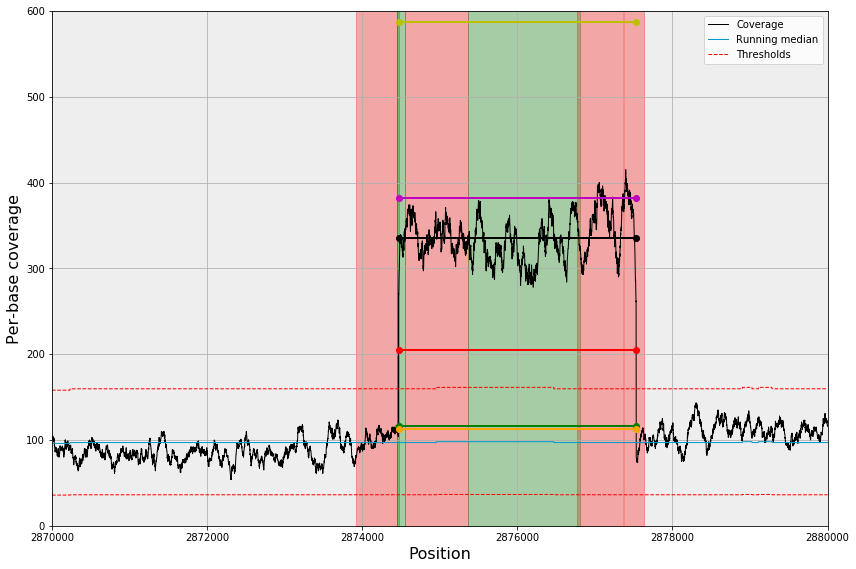

In [20]:
plot_rois(2870000,2880000,ymax=600)
# a duplication with CN = 3 of length 3064
ymax=600

# Those numbers are extracted from the CNOGpro supplementary data file
fill_between([2873916,2874443], ymax,0, color="r", alpha=0.3) # 1,2
fill_between([2874445,2874468], ymax,0, color="g", alpha=0.3) # 2
fill_between([2874444,2874552], ymax,0, color="g", alpha=0.3) # 1,2,3
fill_between([2874553,2875368], ymax,0, color="r", alpha=0.3) # 3
fill_between([2875361,2876803], ymax,0, color="g", alpha=0.3) # 3
fill_between([2876775,2877368], ymax,0, color="r", alpha=0.3) # 1,3,4 
fill_between([2877369,2877631], ymax,0, color="r", alpha=0.3) # 1 4



Note that using sequana_coverage, we detect a single event (horizontal colored bars)
Moreover, the boundary is correct in sequana coverage while CNOGpro boundary are 
not as precise on this isolate example. Other isolates show the same type of behaviour.

finally, our CN are equal to 3.3+-0.1 std whereas CN number from CNOGpro seems 
to be more spread with value. In the paper they wrote that 

     "in ERR043367 and ERR043371 the data indicated that tnpR resolvase might 
      be present at a copy number of 4"

Here, we have a estimate of the mean and standard deviation that is 3.3

Here, we can get the average Copy Number for the 6 strains of the ROIs found in between the position 2870000 and 2880000

In [22]:
get_CN(2870000, 2880000)

[3.2791377193958415,
 3.2548903808694933,
 3.1506509773481048,
 3.4403982377910793,
 3.4168564614470482,
 3.2862666489331387]

# Detection of long and short events

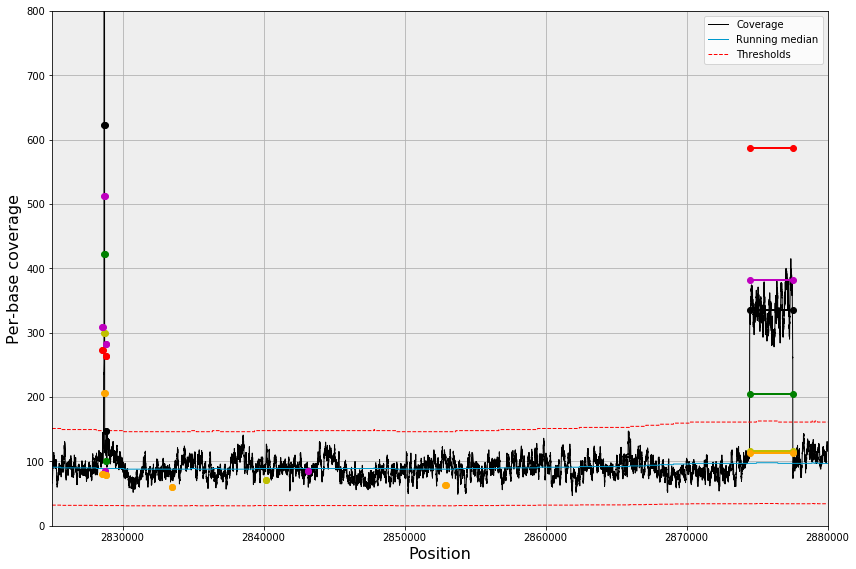

In [23]:
plot_rois(2825000,2880000, ymax=800)


# Comparison CNVnator

```
module load cnvnator
cnvnator -root out1.root -tree ERR043371.bam 
cnvnator -root out1.root -his 100
cnvnator -root out1.root -stat 100
cnvnator -root out1.root -partition 100 -ngc
cnvnator -root out1.root -call 100 -ngc > events_bin100.txt
```

- with bin of 100, got 10 events, took 2 minutes
- **with bin of 20   got 17 events took 10 minutes**
- with bin of 10,  got 25 events, took 3 minutes
- with bin of 1,   got 75 events, took 30 minutes 

In [8]:
from sequana.cnv import CNVnator
cnvnator = CNVnator("events_bin20.txt")
events = cnvnator.df[["start", "end"]]

all_events = []
sel = ["start", "end", "3"]
all_events.append(CNVnator("events_ERR043367_bin15.txt").df[sel])
all_events.append(CNVnator("events_ERR043371_bin41.txt").df[sel])
all_events.append(CNVnator("events_ERR043375_bin69.txt").df[sel])
all_events.append(CNVnator("events_ERR043379_bin27.txt").df[sel])
all_events.append(CNVnator("events_ERR142616_bin2.txt").df[sel])
all_events.append(CNVnator("events_ERR316404_bin76.txt").df[sel])


Note that as compared to CNOGpro or sequana_coverage, there are only a few detections

In [25]:
def plot_event(x1, x2):
    plot_rois(x1-5000, x2+5000)
    fill_between([x1,x2], y1=ylim()[1], alpha=0.3, color="g")

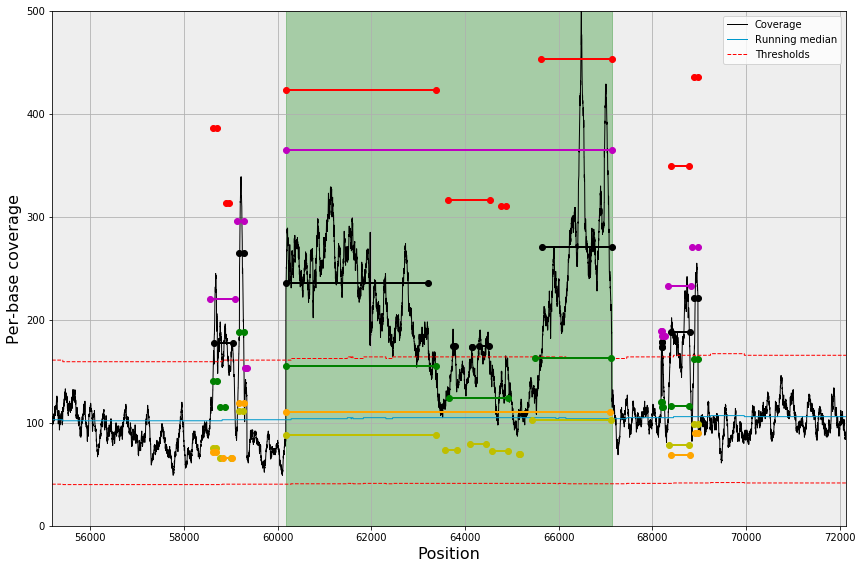

In [26]:
plot_event(*list(events.loc[1]))

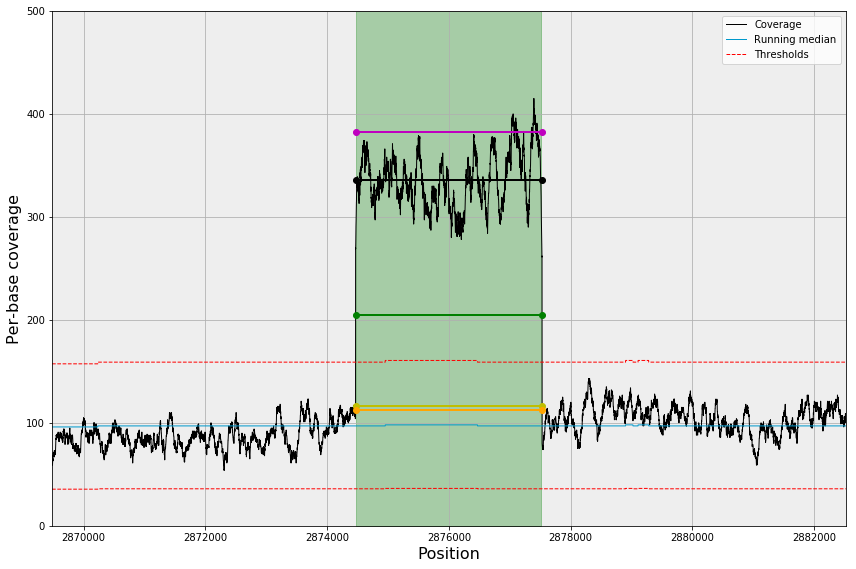

In [27]:
plot_event(*list(events.loc[16]))

ERR043371: 
    - 37-43 CNVs detection in CNORGpro
    - 9 in CNVnator (bin 100 or 41 ; (optimal) )
    - 18 in CNVnator (bin 20)

# Full comparison between CNVnator and sequana (bacteria case)

Please see here:
    
https://github.com/sequana/resources/tree/master/coverage/comparison_cnvnator_bacteria

# False event in CNVnator ? 
amongst  the 17 events detected, some are false alarms like the following event, which is not detected by sequana_coverage (in 5 out of 6 strains)

WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.0030172143883083, m1=1.0378487718952185, sigma0=0.16642943450530537, sigma1=0.20865171545008068


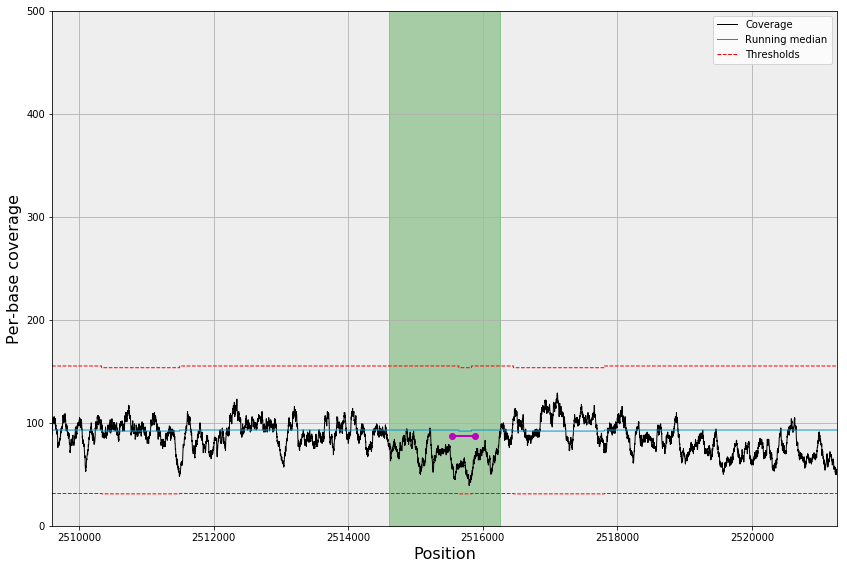

In [28]:
from IPython.display import Image
plot_event(*list(events.loc[15]))


# CNOGpro results

In [9]:
cnogpro = pd.read_csv('ST1.csv')


In [10]:
# Select events 
cnogpro_events = cnogpro.query("CN_HMM!='1'")
cnogpro_events = cnogpro_events[['Left', 'Right']].values
len(cnogpro_events)

43

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WARNING [sequana]:  
Found mixture model parameters (k=2) where  |mu0-mu1| < sigma0. k=1 could be a better choice.mu0=1.0022993606853499, m1=0.9334865514412417, sigma0=0.16583726078356842, sigma1=0.33223109973948645


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

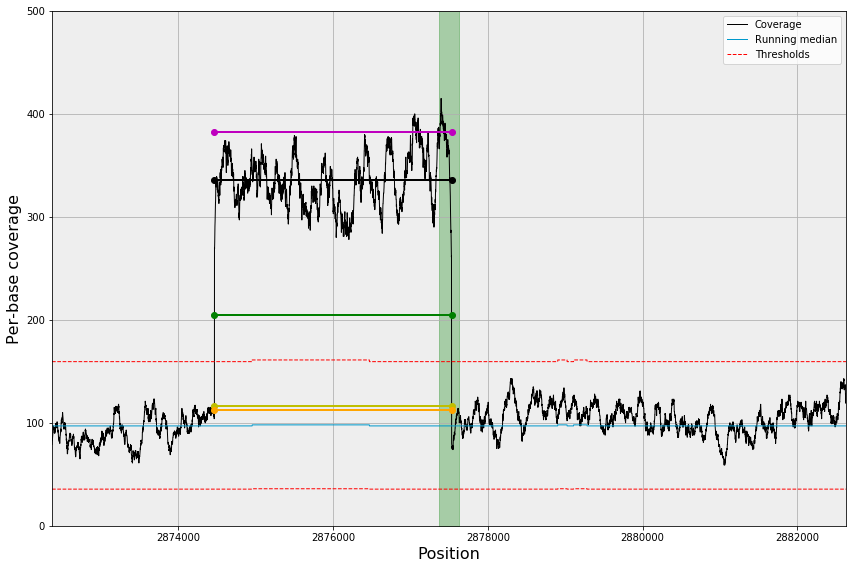

In [31]:
from easydev import Progress
pb = Progress(len(cnogpro_events))
for i, event in enumerate(cnogpro_events):
    plot_event(*event)
    savefig("cnogpro_{}.png".format(i+1))
    pb.animate(i+1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

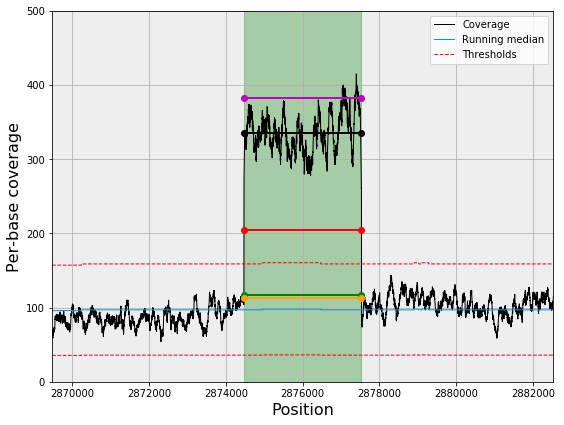

In [89]:
from easydev import Progress

sequana_events = roi4.query('mean_zscore>4.5 or size>60')[['start', 'end']].values
pb = Progress(len(sequana_events))

for i, event in enumerate(sequana_events):
    plot_event(*event)
    savefig("sequana_{}.png".format(i+1))
    pb.animate(i+1)

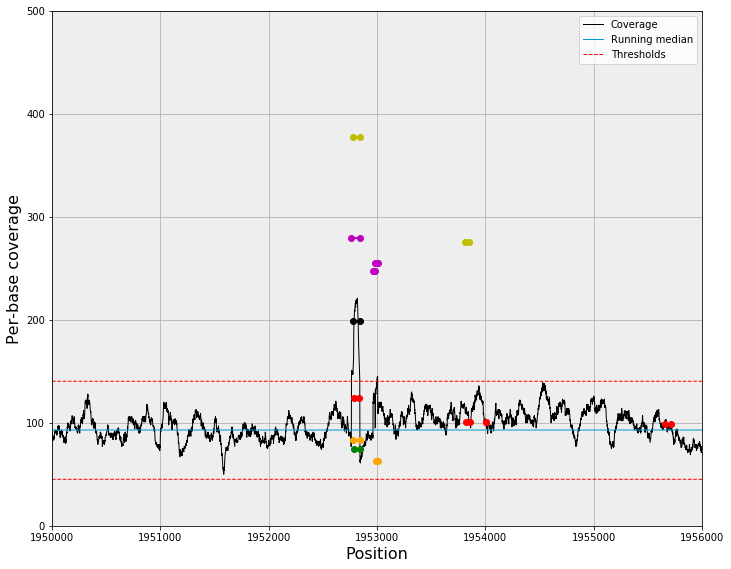

In [31]:
# Event missed by CNOGpro and CNVnator but found by sequana_coverage
plot_rois(1950000, 1956000)

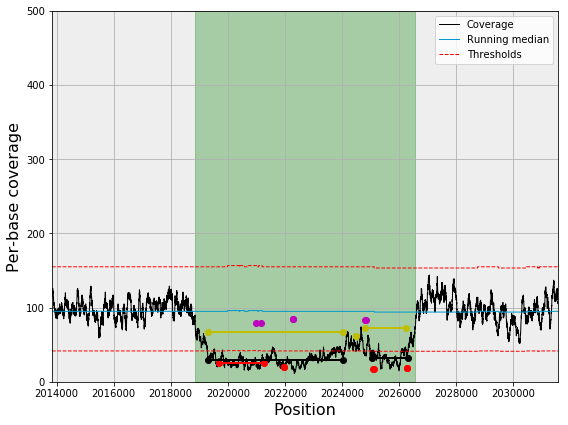

In [92]:
# an event detected by sequana in two parts whereas CNVnator classify this event as a single region
# CNOGpro misses this event and another similar at position 626000
plot_event(2018841,2026580)

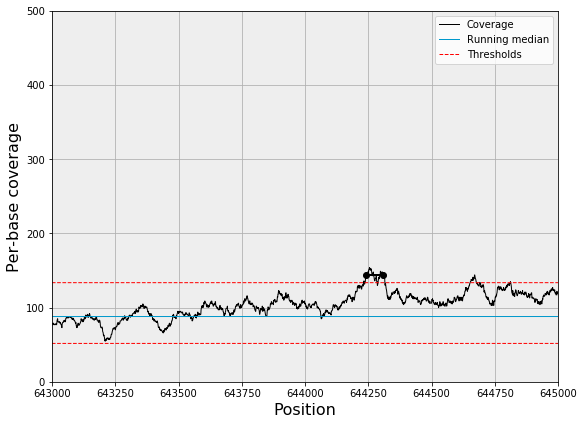

In [321]:
# Sequana false detection example (all false detection have a zscore close to threshold and short length)
plot_rois(643000, 645000)
# here, the running median window size is too large so, the running median does not 
# follow the trend of the data correctly

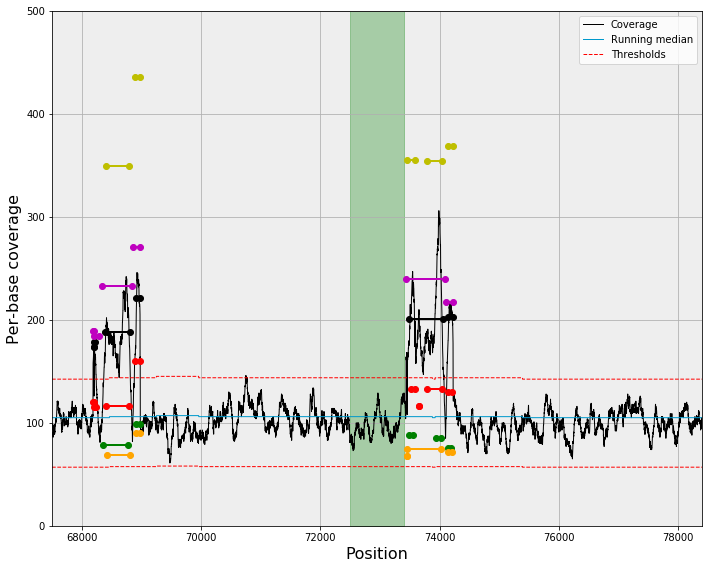

In [33]:
# CNOGpro has false detection next to other events, e.g. 
plot_event(72500, 73400)

WARNING [sequana]:  Warning: k=2 but note that |mu0-mu1| < sigma0. k=1 could be a better choice


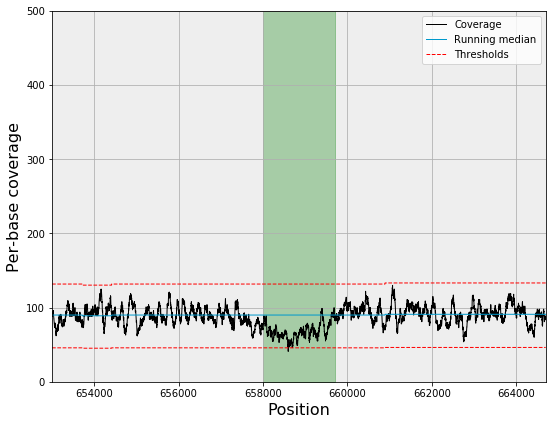

In [326]:
# a false detcetion in CNVnator (3 such events)
plot_event(658000, 659700)

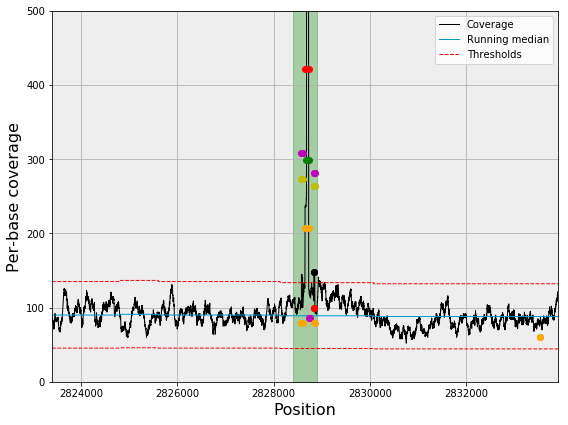

In [334]:
# detected by CNOgpro with bad precision. Missed by cnvnator; Found in sequana_coverage
plot_event(2828400, 2828900)

# Conclusions

We have shown here that sequana_coverage, CNOGpro and CNVnator can detect CNVs from a bacterial genome.

For the comparison, we shown the coverage of the ERR043379 strain but looked at the 6 strains for control (detection in all strains indicates a real event somehow).

The **computational time** of CNOGpro is not known because we took the results from the paper. As for sequana_coverage, it takes less than a minute. For CNVnator, it depends on the bin parameter but oscillates from 1 to 10 minutes.

**CNV detections:**
- CNOGpro file contains 5466 events but we filter the events to keep those with CN_HMM != 1 leading to 43 events.
- CNVnator using a bin of 20 gives 17 events
- sequana_coverage with W=40000 gives about 70 events per strain but many are short events that could be filtered out

**Observations**
- Accuracy
  - CNVnator seems to be the best in the sense of accuracy of location, length of the events and number of events detected. 
  - CNOGpro decomposes events (e.G. event at position ~ 62000) or with 
     detected length quite different from the real value (twice as much at position 2,874,000)
  - sequana_coverage has a behaviour in between CNVnator and CNOgpro.
    true CNVs (CN=2) are well detected like CNVnator
  
- Missed events
  - CNVnator may miss short yet strong events (not CNV). 
  - CNOGPro may miss short yet strong events (not CNV) see e.g. position 
    1,952,000
- False detections:
  - CNVnator detect events e.g. pos 1,956,000 that are not significant
  - CNOGpro detect events e.g. pos 1,956,000 that are not significant
  - sequana_coverage has more short false detections but a simple filter can be used (e.g. size < 60 or |zscore| < 4.5) to select about 30 events

# Extra code: look at the 6 BED files at the same time

In [1]:
from sequana import GenomeCov
b1 = GenomeCov("ERR043367.bed")
b2 = GenomeCov("ERR043371.bed")
b3 = GenomeCov("ERR043375.bed")
b4 = GenomeCov("ERR043379.bed")
b5 = GenomeCov("ERR142616.bed")
b6 = GenomeCov("ERR316404.bed")

In [13]:
def plot_all_rois(m1=85000, m2=90000, ymax=500):    
    i = 0
    f, axes = pylab.subplots(6,1, sharex="col")
    for b, roi, color in zip(
        [b1,b2,b3,b4,b5,b6],
        [roi1, roi2, roi3, roi4, roi5, roi6],
        ["r", "g", "y", "k", "m", "orange"]):
    
        color = "orange"
        chromosome = b.chr_list[0]
        N = len(chromosome.df)
        #chromosome._df = chromosome.df.iloc[max(0,m1-40001): min(m2+40001, N)]
        chromosome.run(40001, k=2)
    
        axes[i].plot(chromosome.df['cov'].loc[m1-20000:m2+40000], color="k", lw=2)
     
        for start, end, cov in zip(roi.start, roi.end, roi.mean_cov):
            if start>m1-20000 and start<m2+40000:
                axes[i].plot([start, end], [cov, cov], lw=2, 
                             color=color, marker="o")
        ymax=chromosome.df['cov'].loc[m1-20000:m2+40000].max()*1.2
        axes[i].set_xlim([m1, m2])
        #axes[i].set_ylim([0,ymax])
        YMAX = axes[i].get_ylim()[1]
        for this in all_events[i].query("start>@m1 and start<@m2+10000").iterrows():
            axes[i].fill_between(this[1][0:2], y1=YMAX, alpha=0.3, edgecolor="k", lw=2 facecolor="g")
            
        #axes[i].fill_between(all_events[i].loc[5], y1=axes[i].get_ylim()[1], alpha=0.3, color="g")
        #axes[i].fill_between(all_events[i].loc[6], y1=axes[i].get_ylim()[1], alpha=0.3, color="g")
        if i==0:
            axes[i].fill_between([86534, 87193] , y1=YMAX/1.5, y2=YMAX, lw=1, facecolor="r", alpha=0.3) #1,2
            axes[i].fill_between([87194, 87231] , y1=YMAX/1.5, y2=YMAX,lw=1, facecolor="g", alpha=0.3) #1,3
            axes[i].fill_between([87231, 89646] , y1=YMAX/1.5, y2=YMAX,lw=1, facecolor="r", alpha=0.3) #1,2,3
        i+=1     


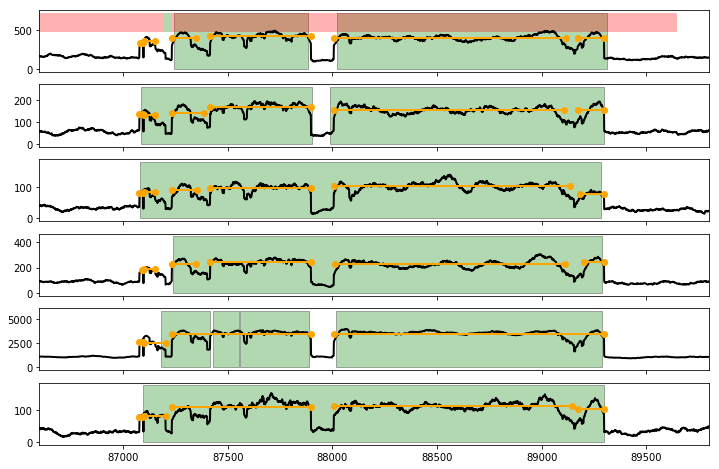

In [14]:
plot_all_rois(86600,89800)
xlabel()

In [14]:
for i in range(6):
    data = all_events[i].query("start>86500 and start<100000")
    print(len(data), data.mean()["3"])

2 2.58786
2 2.61515
1 2.73766
1 2.45888
4 3.4780575
1 3.36399


# How to choose the optimal bin for CNVnator

According the information in the CNVnator paper, bin is inversely proportional to the DOC. Hre are the number for coverage of 30,100 and 500.
This allows us to find the exact equation (2500/DOC) and therefore to extrapolate to larger or smaller DOC

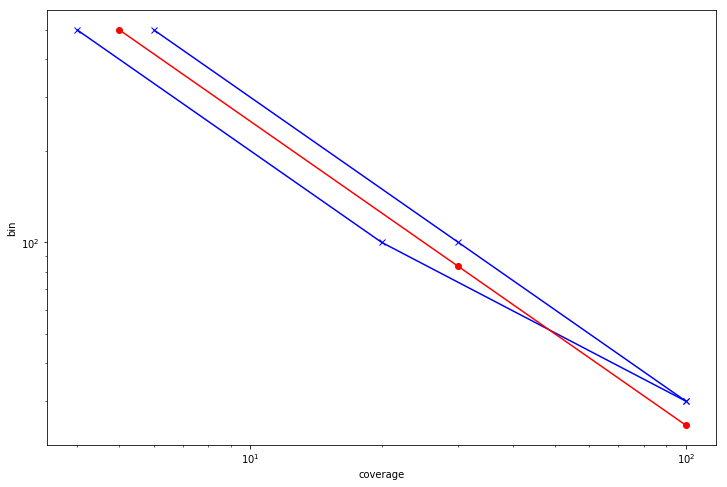

In [61]:
COV = np.array([5,30,100])
# There are two ranges. For instance, bin=500 for coverage in 4-6, so 
# we plot the two intervals (in blue)
loglog([6, 30, 100], [500,100,30], "bx-"); 
loglog([4, 20, 100], [500,100,30], "bx-"); 
xlabel("coverage"); ylabel("bin")
# and figure out a rough estimate of the relationship
loglog(COV, 2500/COV, "or-")

# Figure for the paper

In [9]:

def plot_all_rois_sub():    
    i = 0
    m1 = 86500
    m2 = 90000
    f, axes = pylab.subplots(4,1, sharex="col")
    for b, roi, color, j in zip(
        [b1,b3,b4,b5],
        [roi1,  roi3, roi4, roi5],
        ["r",  "y", "k", "m", ], [0,2,3,4]):
        
        chromosome = b.chr_list[0]
        N = len(chromosome.df)
        #chromosome._df = chromosome.df.iloc[max(0,m1-40001): min(m2+40001, N)]
        chromosome.run(40001, k=2)
    
        axes[i].plot(chromosome.df['cov'].loc[m1-20000:m2+40000], color="k", lw=2)
     
        for start, end, cov in zip(roi.start, roi.end, roi.mean_cov):
            if start>m1-20000 and start<m2+40000:
                axes[i].plot([start, end], [cov, cov], lw=2, 
                             color=color, marker="o")
        ymax=chromosome.df['cov'].loc[m1-20000:m2+40000].max()*1.2
        axes[i].set_xlim([m1, m2])
        #axes[i].set_ylim([0,ymax])
        YMAX = axes[i].get_ylim()[1]
        if i==0:
            axes[i].fill_between([86534,87193] , y1=YMAX/2, y2=YMAX, lw=5, color="r", alpha=0.3) #1,2
            axes[i].fill_between([87194,87231] , y1=YMAX/2, y2=YMAX,lw=5, color="g", alpha=0.3) #1,3
            axes[i].fill_between([87231,89646] , y1=YMAX/2, y2=YMAX,lw=5, color="r", alpha=0.3) #1,2,3
            for this in all_events[j].query("start>86000 and start<100000").iterrows():
                axes[i].fill_between(this[1][0:2], y1=0, y2=YMAX/2, alpha=0.3, color="g")
            
        else:
            # Note that here we use j (not i) to get the corrent events
            for this in all_events[j].query("start>86000 and start<100000").iterrows():
                axes[i].fill_between(this[1][0:2], y1=0, y2=YMAX, alpha=0.3, color="g")
            
        i+=1     


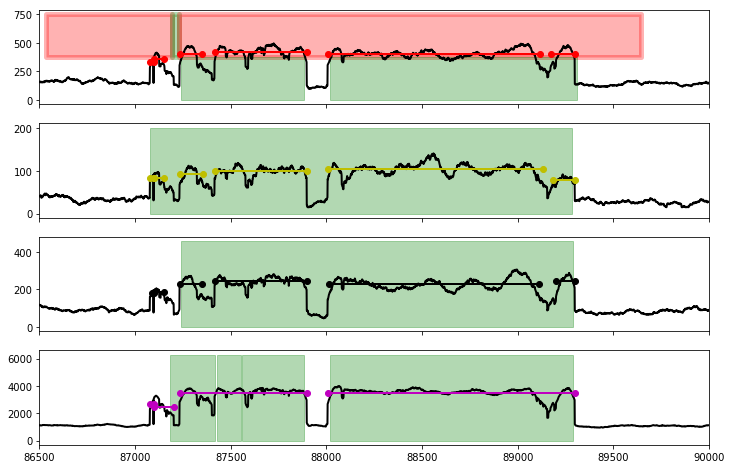

In [25]:
plot_all_rois_sub()

In [40]:
CNV_sequana = [roi.query("start>86000 and start<88000").mean()["log2_ratio"]*2 
               for roi in [roi1, roi2, roi3, roi4, roi5, roi6]]
CNV_cnvnator = [all_events[i].query("start>86500 and start<100000").mean()["3"]
                for i in range(6)]

In [49]:
abs((np.array(CNV_sequana) - np.array(CNV_cnvnator))/np.array(CNV_cnvnator))*100

array([ 21.05130118,  12.45821061,   6.78729878,  16.49772711,
        22.95924166,  15.75885691])

# missed short events 

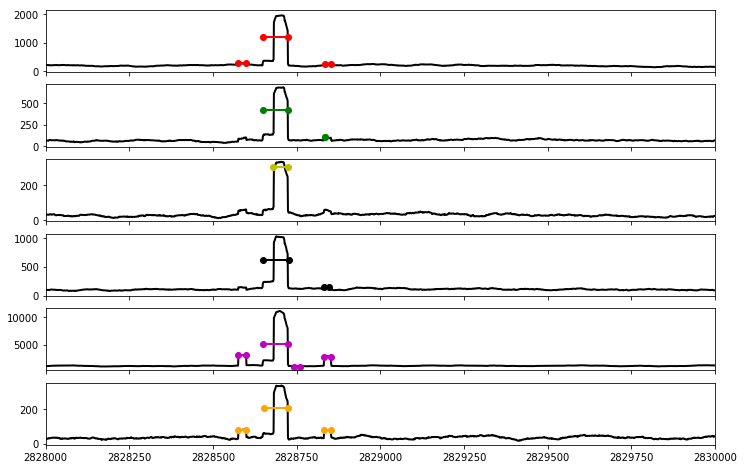

In [18]:
plot_all_rois(2828000,2830000, ymax=800)

In [23]:
[roi.query("start>2828000 and start<2830000").mean()["max_cov"]/roi.query("start>2828000 and start<2830000").mean()["mean_rm"]
               for roi in [roi1, roi2, roi3, roi4, roi5, roi6]]


[5.2658227848101262,
 6.6355932203389827,
 9.1666666666666661,
 6.595505617977528,
 3.3654019873532071,
 5.1212121212121211]